## **References**
Below are references (githubs, blogs, stackoverflow etc) where codes are adapted from and links used for troubleshooting errors encountered during the project.

1. https://towardsdatascience.com/question-and-answering-with-bert-6ef89a78dac

2. https://www.youtube.com/watch?v=scJsty_DR3o

3. Freeze Lower Layers with Auto Classification Model (https://discuss.huggingface.co/t/freeze-lower-layers-with-auto-classification-model/11386, https://huggingface.co/transformers/v3.3.1/training.html

4. Transfer Learning — Powering up with Pretrained Models (https://medium.com/analytics-vidhya/transfer-learning-powering-up-with-pretrained-models-read-bert-ce7da68f3e08)

5. How to deal with -1 span_start and span_end in coQA dataset? (https://www.kaggle.com/discussions/questions-and-answers/365778)

6. https://stackoverflow.com/questions/74417607/how-to-deal-with-1-span-start-and-span-end-in-coqa-dataset-posted-in-questions

7. https://ai.stackexchange.com/questions/32184/what-is-the-intermediate-dense-layer-in-between-attention-output-and-encoder-o

8. How to Build Custom Q&A Transformer Models in Python (https://www.youtube.com/watch?v=ZIRmXkHp0-c , https://gist.github.com/jamescalam/55daf50c8da9eb3a7c18de058bc139a3

## **Install and import relevant libraries and packages. Connect google drive to google colab. Also, set up a GPU/CPU config.**

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 5.5 MB 6.5 MB/s 
     |████████████████████████████████| 182 kB 79.7 MB/s 
     |████████████████████████████████| 7.6 MB 48.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizerFast
import json
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})

In [ ]:
#device config
# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## **COQA DATASET**

## Load Coqa data set

In [ ]:
coqa_train_filename  = "/content/drive/MyDrive/w266_NLP_project/data/CoQA_datasets/coqa-train-v1.0.json"
coqa_val_filename  = "/content/drive/MyDrive/w266_NLP_project/data/CoQA_datasets/coqa-dev-v1.0.json"

In [ ]:
#define function to load json file
def load_data(filename):
  """This will take in a json data file name 
      and convert data to pandas dataframe.
  """
  data = pd.read_json(filename)
  return data



In [ ]:
coqa_train = load_data(coqa_train_filename)
coqa_val = load_data(coqa_val_filename)
coqa_train.head(2)

,version,data
0,1,"{'source': 'wikipedia', 'id': '3zotghdk5ibi9ce..."
1,1,"{'source': 'cnn', 'id': '3wj1oxy92agboo5nlq4r7..."


In [ ]:
#We will delete the column called version as it is not needed.
del coqa_train["version"]
del coqa_val["version"]

In [ ]:
#Define a function to extract the data from the dataframe.
def extract_column_data(df):
  """This function will extract the data from the json data format in the data column of the dataframe and store in a list.
  This is a nested json format. We will obtain the story (which is the context), the questions,
  answers, span start and span end into a dataframe."""
  
#required columns in our dataframe
  cols = ["context","question","convo_answer","span_start","span_end", "span_text"]
  #list of lists to create our dataframe
  data_list = []
  for index, row in df.iterrows():
      for i in range(len(row["data"]["questions"])):
        
          temp_list = []
          temp_list.append(row["data"]["story"])
          temp_list.append(row["data"]["questions"][i]["input_text"])
          temp_list.append(row["data"]["answers"][i]["input_text"])
          temp_list.append(row["data"]["answers"][i]["span_start"])
          temp_list.append(row["data"]["answers"][i]["span_end"])
          temp_list.append(row["data"]["answers"][i]["span_text"])
          data_list.append(temp_list)
  data_df = pd.DataFrame(data_list, columns=cols)
  return data_df

In [ ]:
coqa_train = extract_column_data(coqa_train)
coqa_val = extract_column_data(coqa_val)

coqa_train.head(2)

,context,question,convo_answer,span_start,span_end,span_text
0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,151,179,Formally established in 1475
1,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,454,494,he Vatican Library is a research library


In [ ]:
coqa_val.head(2)

,context,question,convo_answer,span_start,span_end,span_text
0,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,white,59,93,a little white kitten named Cotton
1,"Once upon a time, in a barn near a farm house,...",Where did she live?,in a barn,18,80,"in a barn near a farm house, there lived a lit..."


## Coqa data pre-processing

In [ ]:
coqa_train.loc[coqa_train.span_start<0]

,context,question,convo_answer,span_start,span_end,span_text
13,"The Vatican Apostolic Library (), more commonl...",what must be requested to view?,unknown,-1,-1,unknown
349,(CNN) -- The 54-year-old Michigan tree trimmer...,Were they the relatives of the kid?,unknown,-1,-1,unknown
352,(CNN) -- The 54-year-old Michigan tree trimmer...,Where did he go afterwards?,unknown,-1,-1,unknown
354,(CNN) -- The 54-year-old Michigan tree trimmer...,Who found them?,unknown,-1,-1,unknown
356,(CNN) -- The 54-year-old Michigan tree trimmer...,Did he have any siblings?,unknown,-1,-1,unknown
...,...,...,...,...,...,...
108230,"CHAPTER 6 \n\nCan piety the discord heal, Or s...",Who wanted to end the conversation?,unknown,-1,-1,unknown
108408,Edith Cavell was born in a little English vill...,What happened to him?,unknown,-1,-1,unknown
108581,"CHAPTER XX \n\nFAST IN THE ICE \n\n""Well, ther...",What sort of official did they meet?,unknown,-1,-1,unknown
108632,"Frankfurt, officially Frankfurt am Main (Liter...",Is it the world's biggest?,unknown,-1,-1,unknown


There are some rows with a -1 values in the span_start and span_end column as shown in the table above. These were causing error (OverflowError: can't convert negative int to unsigned) when I was adding token positions (in couple of cells below). There might be couple of ways to handle this but the way I handled it was to exclude those samples from the training samples as I didn't have enough time to dig on the best approach due to running out of time for this project and they only make up about 1.2% of the whole dataset. In addition, one of the participants on the coqa leaderboard (6th position as at 11/16/2022) also used this approach.

In [ ]:
#let's only retain the rows that do not have -1 as their span start and span end.
coqa_train = coqa_train.loc[~coqa_train.span_start<0]
coqa_val = coqa_val.loc[~coqa_val.span_start<0]

In [ ]:
#Verify we removed them.
coqa_train.loc[coqa_train.span_start<0]

,context,question,convo_answer,span_start,span_end,span_text


In [ ]:
print(f"The number of rows in the coqa train dataset is {len(coqa_train)}")
print(f"The number of rows in the coqa val dataset is {len(coqa_val)}")

The number of rows in the coqa train dataset is 107286
The number of rows in the coqa val dataset is 7918


In [ ]:
#Define function to extract the data into list for easy tokenization
def df_to_list(df):
  contexts = []
  questions = []
  convo_answer = []
  answers = []
  context_answer_span_list_of_list = []
  


  for idx, row in df.iterrows():
    answer_dict = {}  
    contexts.append(row["context"])
    context_list = (row["context"]).split()
    answer_span_list = (row["span_text"]).split()
    context_answer_span_list = context_list + answer_span_list
    context_answer_span_list_of_list.append(context_answer_span_list)
    questions.append(row["question"])
    convo_answer.append(row["convo_answer"])
    answer_dict['text'] = row["span_text"]
    answer_dict['answer_start'] = row["span_start"]
    answer_dict['answer_end'] = row["span_end"]
    answers.append(answer_dict)
    
  return contexts,questions,convo_answer,answers, context_answer_span_list_of_list

In [ ]:
coqa_train_contexts, coqa_train_questions, coqa_train_convo_answer, coqa_train_answers, coqa_train_context_answer_span_list_of_list = df_to_list(coqa_train)
coqa_val_contexts, coqa_val_questions, coqa_val_convo_answer, coqa_val_answers, coqa_val_context_answer_span_list_of_list = df_to_list(coqa_val)

Let's take a look at a representative of the contexts, answer, span start and span end. We will look at the first example.

In [ ]:

coqa_train_answers[13]

{'text': 'Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. ',
 'answer_start': 643,
 'answer_end': 764}

In [ ]:
coqa_val_answers[0]

{'text': 'a little white kitten named Cotton',
 'answer_start': 59,
 'answer_end': 93}

In [ ]:
#Let us create a function to check the maximum length for our combined questions and answers for both train and val dataset.

def check_max_list_len(d_list):
  context_answer_max_len = 0

  for mylist in d_list:
    d_length = len(mylist)
    if d_length > context_answer_max_len:
      context_answer_max_len = d_length
    else:
      context_answer_max_len = context_answer_max_len
  return (context_answer_max_len)

In [ ]:
max_length_train = check_max_list_len(coqa_train_context_answer_span_list_of_list)
max_length_val = check_max_list_len(coqa_val_context_answer_span_list_of_list)

print(f'The max length for questions and answers combined in train set is {max_length_train}')
print(f'The max length for questions and answers combined in val set is {max_length_val}')

The max length for questions and answers combined in train set is 1090
The max length for questions and answers combined in val set is 831


Since BERT can be off in the answer due to the special tokens (CLS and SEP), we would create a function to cater for this offset.

In [ ]:
def adjust_bert_idx_offset(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        # gold_text refers to the answer we are expecting to find in context
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        
        # and ideally this would be the end index...
        end_idx = answer['answer_end']
        

        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:
                    # this means the answer is off by 'n' tokens
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n

In [ ]:
adjust_bert_idx_offset(coqa_train_answers, coqa_train_contexts)
adjust_bert_idx_offset(coqa_val_answers, coqa_val_contexts)

## Encode Coqa training and val data

We will now go ahead to encode our coqa training data set and the validation dataset. But first, download the DistilBertTokenizerFast tokenizer. This is a light weight tokenizer.

In [ ]:

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
coqa_train_encodings = tokenizer(coqa_train_contexts, coqa_train_questions, truncation=True, padding=True)
coqa_val_encodings = tokenizer(coqa_val_contexts, coqa_val_questions, truncation=True, padding=True)

In [ ]:
coqa_val_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
#Define a function to update the token start and end position in our encodings.
def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # print(i)
        # append start/end token position using char_to_token method
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
                 
                  
      
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))
        
      

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift one token forward
        go_back = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end']-go_back)
            go_back +=1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})



In [ ]:
# apply function to our data
add_token_positions(coqa_train_encodings, coqa_train_answers)
add_token_positions(coqa_val_encodings, coqa_val_answers)

##Evaluation Function

In [ ]:
#define a function to evaluate a model on a validation dataset

def evaluate_on_model(model, val_dataset):
  """This function would take in the model and the validation dataset as input.
  Output - acc, f1_score, true span start position, true span end position, 
           predicted span start position, predicted span end position, inputIDs
  """

  model.to(device)
  # switch model out of training mode
  model.eval()

  #val_sampler = SequentialSampler(val_dataset)
  val_loader = DataLoader(val_dataset, batch_size=16)

  acc = []
  f1_score = []  
  my_start_true = []
  my_end_true = []
  my_start_pred = []  
  my_end_pred = []
  my_inputIDs = []

  # initialize loop for progress bar
  loop = tqdm(val_loader)
  # loop through batches
  for batch in loop:
      # we don't need to calculate gradients as we're not training
      with torch.no_grad():
          # pull batched items from loader
          input_ids = batch['input_ids'].to(device)
          my_inputIDs.append(input_ids)
          attention_mask = batch['attention_mask'].to(device)
          start_true = batch['start_positions'].to(device)
          my_start_true.append((start_true))
          end_true = batch['end_positions'].to(device)
          my_end_true.append((end_true))
          answer_true_logits = torch.cat((start_true, end_true)).to(device)
          
          # make predictions
          outputs = model(input_ids, attention_mask=attention_mask)
          # pull preds out
          start_pred = torch.argmax(outputs['start_logits'], dim=1)
          my_start_pred.append((start_pred))
          end_pred = torch.argmax(outputs['end_logits'], dim=1)
          my_end_pred.append((end_pred))
          answer_pred_logits = torch.cat((start_pred, end_pred))
          
          # calculate accuracy for both and append to accuracy list
          acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
          acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

          # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
          if len(answer_pred_logits) == 0 or len(answer_true_logits) == 0:
            f1_score.append((float(answer_pred_logits == answer_true_logits)).item())

          #Grab tokens common to both prediction and true logits.
          common_tokens = [num for num in answer_pred_logits if num in answer_true_logits]         

          prec = len(common_tokens) / len(answer_pred_logits)
                    
          rec = (len(common_tokens) / len(answer_true_logits))
          
          try:
            f1_score.append(2 * (prec * rec) / (prec + rec))
          except ZeroDivisionError:
            f1_score.append(float(0))

  # calculate average accuracy in total and f1 score.
  acc = sum(acc)/len(acc)
  f1_score = sum(f1_score)/len(f1_score)
  print(" ")
  print(f"Exact Match accuracy is: {acc}")
  print(f"F1 score is: {f1_score}")
  return acc, f1_score, my_start_true, my_end_true, my_start_pred, my_end_pred, my_inputIDs

##Create Coqa train and Val dataset using Pytorch Dataset class

In [ ]:
class CoqaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):

      """This helps with data loading"""
      self.encodings = encodings

    def __getitem__(self, idx):
      """This will allow for indexing so we can call dataset[0] for example"""
      return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
      """This will allow us to call length of of our sample"""
      return len(self.encodings.input_ids)

coqa_train_dataset = CoqaDataset(coqa_train_encodings)
coqa_val_dataset = CoqaDataset(coqa_val_encodings)

In [ ]:
#Define function to plot training loss
def plot_loss(num_epochs, model_loss):
  x = [x for x in range(1, num_epochs+1)]
  y = [y for y in model_loss]
  plt.plot(x, y, linewidth = 3) 
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.show()

# **Model 1 - Baseline** 


### Baseline Evaluation

The baseline model is a distilbert model with a question and answering head downloaded directly from the hugging face hub and evaluated on the coqa val dataset without undergoing any fine-tuning.

In [ ]:
#Evaluate model baseline. No fine tuning needed.
model_noFineTuning = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

model = model_noFineTuning
val_dataset = coqa_val_dataset
model_noFineTuning_accuracy, model_noFineTuning_f1_score, model_noFineTuning_start_true_coqa, model_noFineTuning_end_true_coqa, model_noFineTuning_start_pred_coqa, model_noFineTuning_end_pred_coqa, model_noFineTuning_inputIDs = evaluate_on_model(model, val_dataset)



Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

 
Exact Match accuracy is: 0.00523989898989899
F1 score is: 0.08920454545454545


# **Fine Tune model on coqa training dataset**


Download DistilBert model with a question and answering head from hugging face repo

In [ ]:
#save the pretrained model
model_fineTune_on_coqa = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

Define a function that would be used for fine-tuning the models. This function has some conditional statements that would be used in freezing some of the model layers during fine-tuning.

In [ ]:


# setup GPU/CPU
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device

def train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs):
  model.to(device)
  # activate training mode of model

  #freezing some layers
  for name, param in model.named_parameters():
     if name.startswith("distilbert.transformer.layer.0."): 
        param.requires_grad = False

     if name.startswith("distilbert.transformer.layer.1."): 
        param.requires_grad = False

     if name.startswith("distilbert.transformer.layer.2."): 
        param.requires_grad = False

     if name.startswith("distilbert.transformer.layer.3."):
        param.requires_grad = False

  #    if name.startswith("distilbert.transformer.layer.4."):
  #       param.requires_grad = False

      
  model.train()
  # initialize adam optimizer with weight decay (reduces chance of overfitting)
  optim = AdamW(model.parameters(), lr=learning_rate)

  # initialize data loader for training data
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  epoch_loss = []

  for epoch in range(num_epochs):
      
      # set model to train mode
      model.train()
      # setup loop (we use tqdm for the progress bar)
      loop = tqdm(train_loader, leave=True)
      batch_loss = []
      for batch in loop:
          # initialize calculated gradients (from prev step)
          optim.zero_grad()
          
          # pull all the tensor batches required for training
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          start_positions = batch['start_positions'].to(device)
          end_positions = batch['end_positions'].to(device)
          # train model on batch and return outputs (incl. loss)
          outputs = model(input_ids, attention_mask=attention_mask,
                          start_positions=start_positions,
                          end_positions=end_positions)
          # extract loss
          loss = outputs[0]
          # calculate loss for every parameter that needs grad update
          loss.backward()
          # update parameters
          optim.step()
          # print relevant info to progress bar
          loop.set_description(f'Epoch {epoch+1}')
          loop.set_postfix(loss=loss.item())      
      epoch_loss.append((loss).item())      
  return model, epoch_loss


  

# **Model 2** 




In [ ]:
#Here I will freeze layers 0, 1, 2, 3 of distilBERT.
#MODEL 2
model = model_fineTune_on_coqa
train_dataset = coqa_train_dataset
val_dataset = coqa_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 1

model2_fineTune_on_coqa, model2_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

x = model2_loss

model = model2_fineTune_on_coqa

#Evaluate model on coqa validation dataset

model2_fineTuned_on_coqa_accuracy, model2_fineTuned_on_coqa_f1_score, model2_start_true_coqa, model2_end_true_coqa, model2_start_pred_coqa, model2_end_pred_coqa, model2_inputIDs = evaluate_on_model(model, val_dataset)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 495/495 [00:31<00:00, 15.93it/s]

 
Exact Match accuracy is: 0.2865440115633637
F1 score is: 0.47845418470418466


# **Model 3** 

In [ ]:

#Here, I will freeze layers 0, 1, 2, 3, 4 of BERT.
model = model_fineTune_on_coqa
train_dataset = coqa_train_dataset
val_dataset = coqa_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 1


model3_fineTune_on_coqa, model3_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

x = model3_loss

model = model3_fineTune_on_coqa

#Evaluate model on coqa validation dataset
model3_fineTuned_on_coqa_accuracy, model3_fineTuned_on_coqa_f1_score, model3_start_true_coqa, model3_end_true_coqa, model3_start_pred_coqa, model3_end_pred_coqa, model3_inputIDs = evaluate_on_model(model, val_dataset)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 495/495 [00:31<00:00, 15.91it/s]

 
Exact Match accuracy is: 0.2194264069350079
F1 score is: 0.42415223665223667


# **Model 4** 

In [ ]:
#No layer of BERT would be frozen.
model = model_fineTune_on_coqa
train_dataset = coqa_train_dataset
val_dataset = coqa_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 1


model4_fineTune_on_coqa, model4_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

x = model4_loss

model = model4_fineTune_on_coqa

#Evaluate model on coqa validation dataset
model4_fineTuned_on_coqa_accuracy, model4_fineTuned_on_coqa_f1_score, model4_start_true_coqa, model4_end_true_coqa, model4_start_pred_coqa, model4_end_pred_coqa, model4_inputIDs = evaluate_on_model(model, val_dataset)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 495/495 [00:30<00:00, 16.01it/s]

 
Exact Match accuracy is: 0.3161435787123863
F1 score is: 0.47259199134199137


In [ ]:
#Save the model
coqa_model_path = '/content/drive/MyDrive/w266_NLP_project/savedModel/distilbert-custom'
model4_fineTune_on_coqa.save_pretrained(coqa_model_path)


In [ ]:
#load the model
model = model4_fineTune_on_coqa.from_pretrained(coqa_model_path)

# **Model 5** 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch 3: 100%|██████████| 6706/6706 [21:37<00:00,  5.17it/s, loss=2.85]


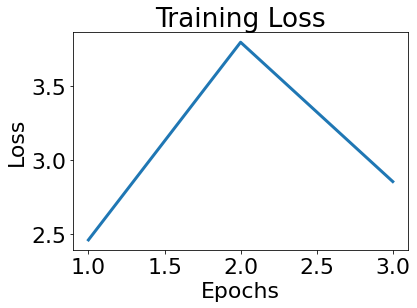

100%|██████████| 495/495 [00:31<00:00, 15.95it/s]

 
Exact Match accuracy is: 0.33211580090450515
F1 score is: 0.48819444444444443


In [ ]:
#No layer of BERT would be frozen.
model = model_fineTune_on_coqa
train_dataset = coqa_train_dataset
val_dataset = coqa_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 3


model5_fineTune_on_coqa, model5_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

x = num_epochs
y = model5_loss
plot_loss(x, y)

model = model5_fineTune_on_coqa

#Evaluate model on coqa validation dataset
model5_fineTuned_on_coqa_accuracy, model5_fineTuned_on_coqa_f1_score, model5_start_true_coqa, model5_end_true_coqa, model5_start_pred_coqa, model5_end_pred_coqa, model5_inputIDs = evaluate_on_model(model, val_dataset)

# **Model 6** 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch 5: 100%|██████████| 6706/6706 [21:32<00:00,  5.19it/s, loss=1.25]


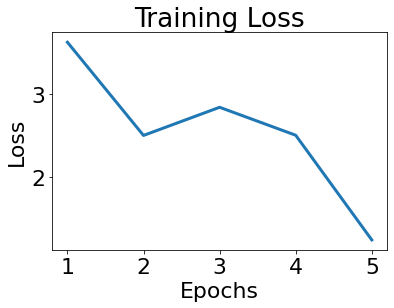

100%|██████████| 495/495 [00:30<00:00, 16.01it/s]

 
Exact Match accuracy is: 0.32048160174880364
F1 score is: 0.4623376623376623


In [ ]:
#No layer of BERT would be frozen.
model = model_fineTune_on_coqa
train_dataset = coqa_train_dataset
val_dataset = coqa_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 5


model6_fineTune_on_coqa, model6_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

x = num_epochs
y = model6_loss
plot_loss(x, y)

model = model6_fineTune_on_coqa

#Evaluate model on coqa validation dataset
model6_fineTuned_on_coqa_accuracy, model6_fineTuned_on_coqa_f1_score, model6_start_true_coqa, model6_end_true_coqa, model6_start_pred_coqa, model6_end_pred_coqa, model6_inputIDs = evaluate_on_model(model, val_dataset)

# **Model 7** 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch 1: 100%|██████████| 3353/3353 [20:08<00:00,  2.78it/s, loss=2.68]


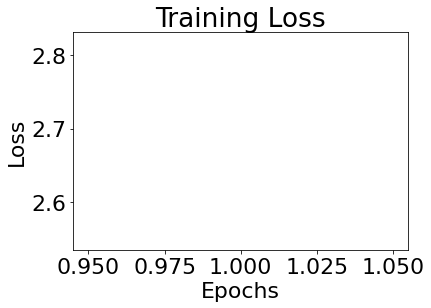

100%|██████████| 495/495 [00:31<00:00, 15.93it/s]

 
Exact Match accuracy is: 0.31902958154678346
F1 score is: 0.4814303751803752


In [ ]:
#No layer of BERT would be frozen.
model = model_fineTune_on_coqa
train_dataset = coqa_train_dataset
val_dataset = coqa_val_dataset
batch_size = 32
shuffle = True
learning_rate = 5e-5
num_epochs = 1


model7_fineTune_on_coqa, model7_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

x = num_epochs
y = model7_loss
plot_loss(x, y)

model = model7_fineTune_on_coqa

#Evaluate model on coqa validation dataset
model7_fineTuned_on_coqa_accuracy, model7_fineTuned_on_coqa_f1_score, model7_start_true_coqa, model7_end_true_coqa, model7_start_pred_coqa, model7_end_pred_coqa, model7_inputIDs = evaluate_on_model(model, val_dataset)

The results of the models shown above show that generally we get a higher F1 score when we have more trainable parameters i.e. lesser or no layer is frozen.

# **SQUAD 2.0 DATASET**

### Load Squad 2.0 data set

In [ ]:
squad_train_path = '/content/drive/MyDrive/w266_NLP_project/data/SQUAD_datasets/train-v2.0.json'
squad_eval_path = '/content/drive/MyDrive/w266_NLP_project/data/SQUAD_datasets/dev-v2.0.json'

In [ ]:
#Define function to read squad 2.0 dataset.
def read_squad(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    # iterate through all data in squad data
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                if 'plausible_answers' in qa.keys():
                    access = 'plausible_answers'
                else:
                    access = 'answers'
                for answer in qa['answers']:
                    # append data to lists
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    # return formatted data lists
    return contexts, questions, answers

In [ ]:
squad_train_contexts, squad_train_questions, squad_train_answers = read_squad(squad_train_path)
squad_val_contexts, squad_val_questions, squad_val_answers = read_squad(squad_eval_path)

In [ ]:
#Let's have an example contexts
squad_train_contexts[0]

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [ ]:
#Let's have an example answer
squad_train_answers[0]

{'text': 'in the late 1990s', 'answer_start': 269}

Since BERT can be off in the answer due to the special tokens (CLS and SEP), we would create a function to cater for this offset.

In [ ]:
def squad_add_end_idx(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        # gold_text refers to the answer we are expecting to find in context
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)

        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:
                    # this means the answer is off by 'n' tokens
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n

In [ ]:
squad_add_end_idx(squad_train_answers, squad_train_contexts)
squad_add_end_idx(squad_val_answers, squad_val_contexts)

## Encode

In [ ]:
squad_train_encodings = tokenizer(squad_train_contexts, squad_train_questions, truncation=True, padding=True)
squad_val_encodings = tokenizer(squad_val_contexts, squad_val_questions, truncation=True, padding=True)

Update the start and end token positions

In [ ]:
add_token_positions(squad_train_encodings, squad_train_answers)
add_token_positions(squad_val_encodings, squad_val_answers)

##Create Squad train and Val dataset using Pytorch Dataset class

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)
squad_train_dataset = SquadDataset(squad_train_encodings)
squad_val_dataset = SquadDataset(squad_val_encodings)

## Fine Tune model on squad 2.0 training dataset and then evaluate on squad validated dataset.

In [ ]:
model_fineTune_on_squad = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

# **Model 8** 

In [ ]:
#Here I will freeze layers 0, 1, 2, 3 of BERT.

model = model_fineTune_on_squad
train_dataset = squad_train_dataset
val_dataset = squad_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 1


model8_fineTune_on_squad, model8_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

# x = num_epochs
# y = model8_loss
# plot_loss(x, y)

model = model8_fineTune_on_squad
model8_fineTune_on_squad_accuracy, model8_fineTune_on_squad_f1_score, model8_start_true_squad, model8_end_true_squad, model8_start_pred_squad, model8_end_pred_squad, model8_inputIDs_squad = evaluate_on_model(model, val_dataset)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 1269/1269 [01:19<00:00, 15.90it/s]

 
Exact Match accuracy is: 0.5992344928578047
F1 score is: 0.7768490374873354


# **Model 9** 

In [ ]:
#Here I will freeze layers 0, 1, 2, 3, 4 of BERT.

model = model_fineTune_on_squad
train_dataset = squad_train_dataset
val_dataset = squad_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 1


model9_fineTune_on_squad, model9_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

# x = num_epochs
# y = model9_loss
# plot_loss(x, y)

model = model9_fineTune_on_squad

model9_fineTune_on_squad_accuracy, model9_fineTune_on_squad_f1_score, model9_start_true_squad, model9_end_true_squad, model9_start_pred_squad, model9_end_pred_squad, model9_inputIDs_squad = evaluate_on_model(model, val_dataset)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 1269/1269 [01:19<00:00, 15.90it/s]

 
Exact Match accuracy is: 0.49559903750746526
F1 score is: 0.678585500394011


# **Model 10** 

In [ ]:
#No Bert layer is frozen

model = model_fineTune_on_squad
train_dataset = squad_train_dataset
val_dataset = squad_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 1


model10_fineTune_on_squad, model10_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

# x = num_epochs
# y = model10_loss
# plot_loss(x, y)

model = model10_fineTune_on_squad
model10_fineTune_on_squad_accuracy, model10_fineTune_on_squad_f1_score, model10_start_true_squad, model10_end_true_squad, model10_start_pred_squad, model10_end_pred_squad, model10_inputIDs_squad = evaluate_on_model(model, val_dataset)

100%|██████████| 1269/1269 [01:19<00:00, 16.00it/s]

 
Exact Match accuracy is: 0.6576466283975998
F1 score is: 0.8259983958122256


In [ ]:
#Save the model
squad_model_path = '/content/drive/MyDrive/w266_NLP_project/savedModel/squad_distillbert_custom'
model10_fineTune_on_squad.save_pretrained(squad_model_path)

In [ ]:
#load the model
model = model10_fineTune_on_squad.from_pretrained(coqa_model_path)

# **Model 11** 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch 3: 100%|██████████| 5427/5427 [17:32<00:00,  5.16it/s, loss=0.278]


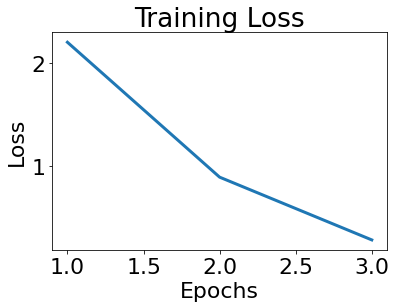

100%|██████████| 1269/1269 [01:19<00:00, 15.87it/s]

 
Exact Match accuracy is: 0.6500443262411347
F1 score is: 0.8178930260047281


In [ ]:
#No Bert layer is frozen

model = model_fineTune_on_squad
train_dataset = squad_train_dataset
val_dataset = squad_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 3



model11_fineTune_on_squad, model11_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

x = num_epochs
y = model11_loss
plot_loss(x, y)

model = model11_fineTune_on_squad
model11_fineTune_on_squad_accuracy, model11_fineTune_on_squad_f1_score, model11_start_true_squad, model11_end_true_squad, model11_start_pred_squad, model11_end_pred_squad, model11_inputIDs_squad = evaluate_on_model(model, val_dataset)

# **Model 12** 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch 5: 100%|██████████| 5427/5427 [17:30<00:00,  5.16it/s, loss=1.27]


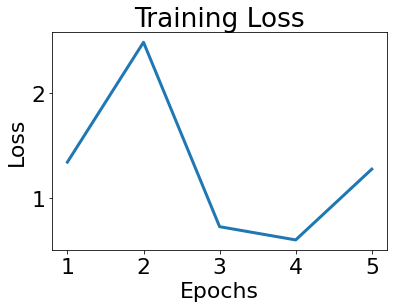

100%|██████████| 1269/1269 [01:19<00:00, 15.90it/s]

 
Exact Match accuracy is: 0.6476556343695045
F1 score is: 0.8143223010244287


In [ ]:
#No Bert layer is frozen

model = model_fineTune_on_squad
train_dataset = squad_train_dataset
val_dataset = squad_val_dataset
batch_size = 16
shuffle = True
learning_rate = 5e-5
num_epochs = 5



model12_fineTune_on_squad, model12_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

x = num_epochs
y = model12_loss
plot_loss(x, y)

model = model12_fineTune_on_squad
model12_fineTune_on_squad_accuracy, model12_fineTune_on_squad_f1_score, model12_start_true_squad, model12_end_true_squad, model12_start_pred_squad, model12_end_pred_squad, model12_inputIDs_squad = evaluate_on_model(model, val_dataset)

# **Model 13** 

In [ ]:
#No Bert layer is frozen

model = model_fineTune_on_squad
train_dataset = squad_train_dataset
val_dataset = squad_val_dataset
batch_size = 32
shuffle = True
learning_rate = 5e-5
num_epochs = 1



model13_fineTune_on_squad, model13_loss = train_model(model, train_dataset, batch_size, shuffle, learning_rate, num_epochs)

# x = num_epochs
# y = model13_loss
# plot_loss(x, y)

model = model13_fineTune_on_squad
model13_fineTune_on_squad_accuracy, model13_fineTune_on_squad_f1_score, model13_start_true_squad, model13_end_true_squad, model13_start_pred_squad, model13_end_pred_squad, model13_inputIDs_squad = evaluate_on_model(model, val_dataset)
model13_fineTune_on_squad_accuracy, model13_fineTune_on_squad_f1_score = evaluate_on_model(model, val_dataset)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 1269/1269 [01:19<00:00, 15.92it/s]

 
Exact Match accuracy is: 0.6582868963251018
F1 score is: 0.8231031183158842


Fine-tuning models on the Squad 2.0 dataset and evaluating on the squad 2.0 validation dataset also show that the lesser the number of layers frozen, the better the model performance.


Now, since model 10 gave us a better model performance when evaluated on the squad 2.0 dataset, we would then evaluate it on the coqa validation dataset so we could compare its performance with that of the model fine-tuned on the coqa dataset.

## Evaluate Squad Best Fine-Tuned Model (Model 10) on coqa Validation dataset

In [ ]:
model = model10_fineTune_on_squad
val_dataset = coqa_val_dataset

model_ft_on_squad_eval_on_coqa_acc, model_ft_on_squad_eval_on_coqa_f1_score, my_start_true_squad, my_end_true_squad, my_start_pred_squad, my_end_pred_squad, my_inputIDs_squad = evaluate_on_model(model, val_dataset)
# model_ft_on_squad_eval_on_coqa_acc, model_ft_on_squad_eval_on_coqa_f1_score = evaluate_on_model(model, val_dataset)

100%|██████████| 495/495 [01:08<00:00,  7.22it/s]

 
Exact Match accuracy is: 0.17050865802048432
F1 score is: 0.30113636363636365


We can see that the DistilBert model fine-tuned on the CoQA dataset outperforms the model fine-tuned on the SQuAD dataset by about 19.04% F1 score when both are evaluated on the CoQA validation dataset. This might be due to the fact it was actually fine-tuned on the CoQA dataset itself. However, we can see that the DistilBert model did perform better on the SQuAD 2.0 dataset than on the CoQA when each of them were evaluated on their respective validation dataset. We can attribute this to the conversational nature of questions in the CoQA dataset as being very challenging.

# **Compare coqa and squad dataset** 

In [ ]:
coqa_train_df = coqa_train.copy()
coqa_train_df.head(3)

,context,question,convo_answer,span_start,span_end,span_text
0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,151,179,Formally established in 1475
1,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,454,494,he Vatican Library is a research library
2,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",457,511,Vatican Library is a research library for hist...


In [ ]:
squad_train_df = pd.DataFrame(list(zip(squad_train_contexts, squad_train_questions,squad_train_answers)),
               columns =['context', 'question', 'answer'])

squad_train_df.head(3)

,context,question,answer
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': 'in the late 1990s', 'answer_start': ..."
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': 'singing and dancing', 'answer_start'..."
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': '2003', 'answer_start': 526}"


In [ ]:
#Define a function to determine and plot the frequency of first word in each question of either a coqa or squad 2.0 dataset.
def plot_first_word_in_each_question(dataset, name_of_dataset, n):
  """
  dataset - Is the dataset filename or variable name
  n - Is the top n words. e.g. n=20 means the top 20 words that begins any question in the respective dataset.
  """
  first_word_count = {}
  for idx, row in dataset.iterrows():
    first_wrd = row["question"].split()[0]
    if first_wrd in first_word_count:
      first_word_count[first_wrd] += 1
    else:
      first_word_count[first_wrd] = 1

  first_word_count_df = pd.DataFrame(list(first_word_count.items()),columns = ['Words','Frequency'])
  first_word_count_df= first_word_count_df.sort_values('Frequency', ascending = False )[0:n]
  plt.figure(figsize=(10,6))
  plt.bar('Words', 'Frequency',data=first_word_count_df)
  plt.xlabel("Words")
  plt.ylabel("Count of words")
  plt.title(f"Frequency of first word in each question in {name_of_dataset} dataset", size = 18)
  plt.xticks(rotation = 90) 



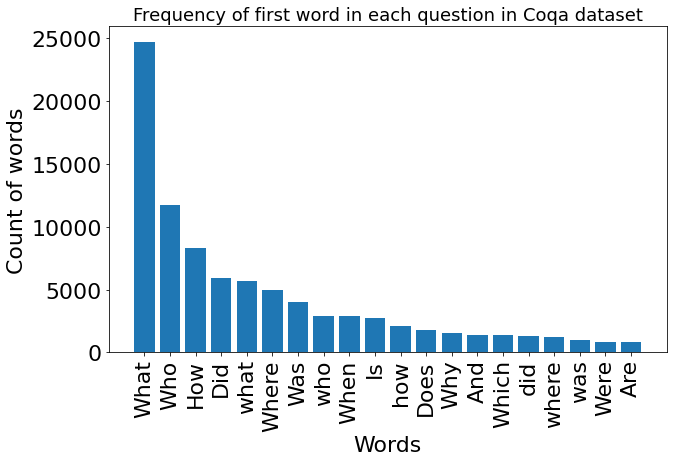

In [ ]:
plot_first_word_in_each_question(coqa_train_df, 'Coqa', 20)

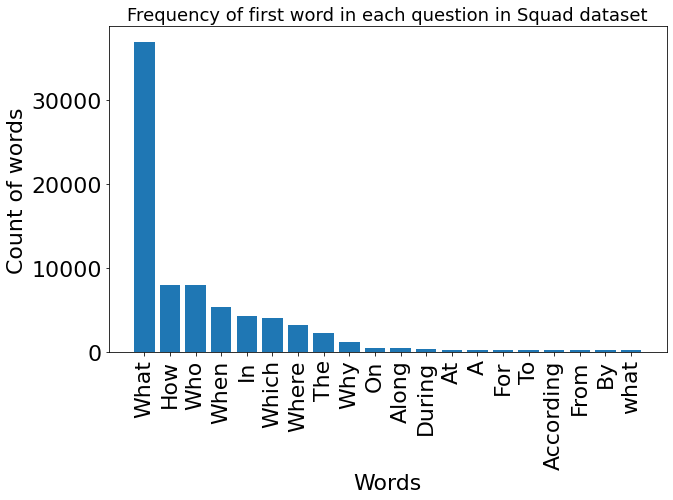

In [ ]:
plot_first_word_in_each_question(squad_train_df, 'Squad', 20)

In [ ]:
#Define a function to determine and plot the frequency of length of question in the dataset.


def plot_len_word_count_in_each_question(dataset, name_of_dataset, n):
  """ dataset - Is the dataset filename or variable name
  n - Is the top n longest questions. e.g. n=20 means the top 20 questions with the longest length in the respective dataset.
  """

  length_of_question_count = {}
  for idx, row in dataset.iterrows():
    # if idx == 1:
    #   break
    length_of_ques = str(len(row["question"].split()))
    if length_of_ques in length_of_question_count:
        length_of_question_count[length_of_ques] += 1
    else:
      length_of_question_count[length_of_ques] = 1
  len_ques_count_df = pd.DataFrame(list(length_of_question_count.items()),columns = ['Number_of_words','Frequency'])
  len_ques_count_df= len_ques_count_df.sort_values('Frequency', ascending = False )[0:n]
  plt.figure(figsize=(10,6))
  plt.bar('Number_of_words', 'Frequency',data=len_ques_count_df)
  plt.xlabel("Number_of_words")
  plt.ylabel("Frequency")
  plt.title(f"Frequency of length of question in {name_of_dataset} dataset", size = 18)
  # plt.xticks(rotation = 90) 

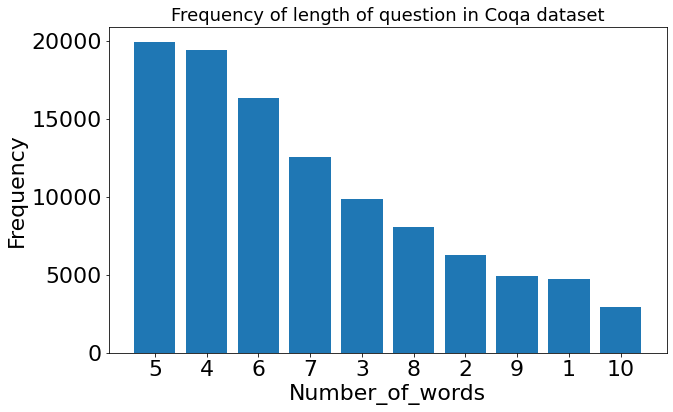

In [ ]:
plot_len_word_count_in_each_question(coqa_train_df, 'Coqa', 10)

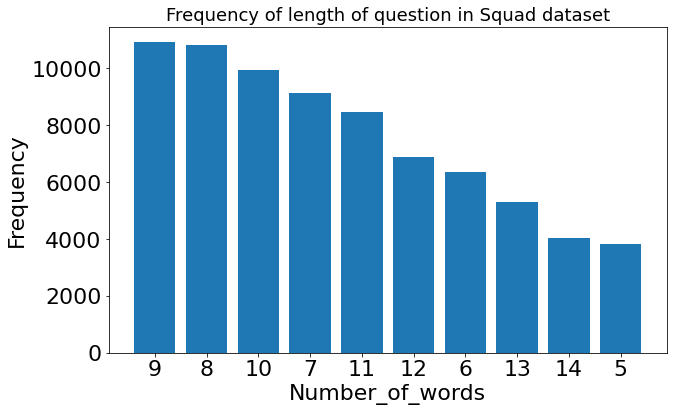

In [ ]:
plot_len_word_count_in_each_question(squad_train_df, 'Squad', 10) 

The analysis of both datasets above showed that there are major differences. Nearly half of SQuAD 2.0 questions are dominated by “what” questions whereas the CoQA dataset has a distribution of other words such as “who”, “how”, “did”, “where”, “was” although questions starting with “what” still took a larger pie of the distribution.
Also, if you take a look at the length of the questions in both SQuAD 2.0 and CoQA above,  the CoQA datasets questions are usually shorter compared to questions in the SQuAD 2.0 dataset. This might be due to the conversational nature of the datasets. We can also see that there are a number of questions in the CoQA datasets that only have a length of either 1, 2 or 3 words. Such questions would be difficult for machines to answer.


## Comparison of Predictions to ground true answers

#### Model trained on Coqa and Evaluated on CoQA

Now let's take a look at the first eighty questions, their ground truth answers and predicted answers by the models. First, we will take a look at that of model 4 since out of all the models trained and evaluated on CoQA datasets, it gave us the best f1 score.  Then after this, we would take a look at model 10 since it was trained on SQuAD 2.0 but evaluated on CoQA.

In [ ]:
print("T/F Logits\tstart\tend\n")

question_counter = 0
for i in range(len(model4_start_true_coqa)):
  if i == 5:
    break
  
  for j in range(len(model4_start_true_coqa[i])):    
    print(f"Question: {coqa_val_questions[question_counter]}")
    tokens_true = tokenizer.convert_ids_to_tokens(model4_inputIDs[i][j])
    tokens_true_list = tokens_true[model4_start_true_coqa[i][j]:model4_end_true_coqa[i][j]+1]    
    sentence_true = tokenizer.convert_tokens_to_string(tokens_true_list)
    print(f"True Answer: {sentence_true}")
    print(f"True Logits\t{model4_start_true_coqa[i][j]}\t{model4_end_true_coqa[i][j]}")
    # print("")
    tokens_pred = tokenizer.convert_ids_to_tokens(model4_inputIDs[i][j])
    tokens_pred_list = tokens_pred[model4_start_pred_coqa[i][j]:model4_end_pred_coqa[i][j]+1]    
    sentence_pred = tokenizer.convert_tokens_to_string(tokens_pred_list)
    print(f"Pred Answer: {sentence_pred}")
    print(f"Pred Logits\t{model4_start_pred_coqa[i][j]}\t{model4_end_pred_coqa[i][j]}")
    print("")
    question_counter +=1 

T/F Logits	start	end

Question: What color was Cotton?
True Answer: a little white kitten named cotton.
True Logits	16	22
Pred Answer: white kitten named cotton.
Pred Logits	18	22

Question: Where did she live?
True Answer: in a barn near a farm house, there lived a little white kitten
True Logits	6	19
Pred Answer: once upon a time, in a barn near a farm house, there lived a little white kitten named cotton.
Pred Logits	1	22

Question: Did she live alone?
True Answer: cotton wasn ' t alone
True Logits	46	50
Pred Answer: she shared her hay bed with her mommy and 5 other sisters.
Pred Logits	62	74

Question: Who did she live with?
True Answer: with her mommy and 5 other sisters.
True Logits	67	74
Pred Answer: she shared her hay bed with her mommy and 5 other sisters.
Pred Logits	62	74

Question: What color were her sisters?
True Answer: her sisters were all orange with beautiful white tiger stripes
True Logits	101	110
Pred Answer: 
Pred Logits	75	74

Question: Was Cotton happy that she l

#### Model trained on Squad and Evaluated on CoQA

In [ ]:
print("T/F Logits\tstart\tend\n")

question_counter = 0
for i in range(len(model10_start_true_squad)):
  if i == 5:
    break
  
  for j in range(len(model10_start_true_squad[i])):    
    print(f"Question: {coqa_val_questions[question_counter]}")
    tokens_true = tokenizer.convert_ids_to_tokens(model10_inputIDs_squad[i][j])
    tokens_true_list = tokens_true[model10_start_true_squad[i][j]:model10_end_true_squad[i][j]+1]    
    sentence_true = tokenizer.convert_tokens_to_string(tokens_true_list)
    print(f"True Answer: {sentence_true}")
    print(f"True Logits\t{model10_start_true_squad[i][j]}\t{model10_end_true_squad[i][j]}")
    # print("")
    tokens_pred = tokenizer.convert_ids_to_tokens(model10_inputIDs_squad[i][j])
    tokens_pred_list = tokens_pred[model10_start_pred_squad[i][j]:model10_end_pred_squad[i][j]+1]    
    sentence_pred = tokenizer.convert_tokens_to_string(tokens_pred_list)
    print(f"Pred Answer: {sentence_pred}")
    print(f"Pred Logits\t{model10_start_pred_squad[i][j]}\t{model10_end_pred_squad[i][j]}")
    print("")
    question_counter +=1 

T/F Logits	start	end

Question: What color was Cotton?
True Answer: a little white kitten named cotton.
True Logits	16	22
Pred Answer: white
Pred Logits	92	92

Question: Where did she live?
True Answer: in a barn near a farm house, there lived a little white kitten
True Logits	6	19
Pred Answer: high up in a nice warm place above the barn
Pred Logits	25	34

Question: Did she live alone?
True Answer: cotton wasn ' t alone
True Logits	46	50
Pred Answer: shared her hay bed with her mommy and 5 other sisters. all of her sisters were cute and fluffy, like cotton. but she was the only white one in the bunch. the rest of her sisters were all orange with beautiful white tiger stripes like cotton ' s mommy. being different made cotton quite sad. she often wished she looked like the rest of her family. so one day, when cotton found a can of the old farmer ' s orange paint, she used it to paint herself like them. when her mommy and sisters found her they started laughing. " what are you doing, cot